In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader

from transformers import T5Tokenizer, T5EncoderModel
from transformers import AdamW
from transformers.modeling_outputs import SequenceClassifierOutput

from tqdm import tqdm

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
# The model is called KE-T5 since it was trained with both Korean and Englihsh
# The vocabulary consists of 64,000 sub-word tokens
MODEL_NAME = 'KETI-AIR/ke-t5-large'
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

In [11]:
from dataset.dataset import T5Dataset
from dataset.preprocessor.preprocessors import T5BasicPreprocessor

In [12]:
dataset = T5Dataset(data_dir="/opt/ml/dataset/")
preprocessor = T5BasicPreprocessor()

dataset.set_tokenizer(tokenizer)
dataset.set_preprocessor(preprocessor)

In [13]:
dataset.preprocess()

Old: 〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey Road》에 담은 노래다.
New: klue_re text: 〈Something〉는 *조지 해리슨*이 쓰고 #비틀즈#가 1969년 앨범 《Abbey Road》에 담은 노래다.
Old: 호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으로 재탄생한다.
New: klue_re text: 호남이 기반인 바른미래당·*대안신당*·#민주평화당#이 우여곡절 끝에 합당해 민생당(가칭)으로 재탄생한다.
Old: K리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터 관중 유치 성과와 마케팅 성과를 인정받아 ‘풀 스타디움상’과 ‘플러스 스타디움상’을 수상했다.
New: klue_re text: K리그2에서 성적 1위를 달리고 있는 *광주FC*는 지난 26일 #한국프로축구연맹#으로부터 관중 유치 성과와 마케팅 성과를 인정받아 ‘풀 스타디움상’과 ‘플러스 스타디움상’을 수상했다.
Old: 균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪고 있는 대구광역시에 행복박스를 전달했다고 10일 밝혔다.
New: klue_re text: 균일가 생활용품점 (주)*아성다이소*(대표 #박정부#)는 코로나19 바이러스로 어려움을 겪고 있는 대구광역시에 행복박스를 전달했다고 10일 밝혔다.
Old: 1967년 프로 야구 드래프트 1순위로 요미우리 자이언츠에게 입단하면서 등번호는 8번으로 배정되었다.
New: klue_re text: *1967*년 프로 야구 드래프트 1순위로 #요미우리 자이언츠#에게 입단하면서 등번호는 8번으로 배정되었다.


In [14]:
for out in dataset:
    for key, value in out.items():
        print(key, value)
    break

input_ids tensor([13724, 27633,   557,    91, 19150,    12, 15072, 25112,  2974,    15,
         4299, 22345, 32874, 24620,    48,  2366,  8278,   394, 10329,  3586,
         4213,  7296,     9,  2370,  2357,    66,     3,     1])
attention_mask tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1])
labels tensor(0)


In [15]:
for out in dataset:
    print(tokenizer.decode(out['input_ids']))
    print(out['labels'])
    break

〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey Road》에 담은 노래다.</s>
tensor(0)


In [16]:
class MeanPooler(nn.Module):
    def __init__(self, dims: int = 1024, dropout_p: float = 0.5):
        super().__init__()
        self.dense1 = nn.Linear(dims, dims)
        self.dense2 = nn.Linear(dims, dims)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, hidden_states, mask, sqrt=True):
        # hidden states: [batch_size, seq, model_dim]
        # attention masks: [batch_size, seq, 1]
        
        sentence_sums = torch.bmm(hidden_states.permute(0, 2, 1), mask.float().unsqueeze(-1)).squeeze(-1)
        divisor = mask.sum(dim=1).view(-1, 1).float()

        if sqrt:
            divisor = divisor.sqrt()
        sentence_sums /= divisor

        pooled_output = self.dense1(sentence_sums)
        pooled_output = F.relu(pooled_output)
        pooled_output = self.dropout(pooled_output)
        pooled_output = self.dense2(pooled_output)
        
        return pooled_output

In [17]:
class T5EncoderForSequenceClassificationMean(nn.Module):
    def __init__(self, num_labels: int = 30, pooler_dims: int = 1024, dropout_p: float = 0.5):

        super(T5EncoderForSequenceClassificationMean, self).__init__()

        self.encoder = T5EncoderModel.from_pretrained(MODEL_NAME)

        self.num_labels = num_labels

        self.pooler = MeanPooler(dims=pooler_dims, dropout_p=dropout_p)
        self.dropout = nn.Dropout(dropout_p)
        self.classifier = nn.Linear(pooler_dims, num_labels)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        Returns:
        Example::
            >>> from transformers import T5Tokenizer, T5EncoderModel
            >>> tokenizer = T5Tokenizer.from_pretrained('t5-small')
            >>> model = T5EncoderModel.from_pretrained('t5-small')
            >>> input_ids = tokenizer("Studies have been shown that owning a dog is good for you", return_tensors="pt").input_ids  # Batch size 1
            >>> outputs = model(input_ids=input_ids)
            >>> last_hidden_states = outputs.last_hidden_state
        """
        return_dict = True

        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            inputs_embeds=inputs_embeds,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        last_hidden_state = outputs[0]

        pooled_output = self.pooler(last_hidden_state, attention_mask)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [18]:
model = T5EncoderForSequenceClassificationMean()
model.to(device)

Some weights of the model checkpoint at KETI-AIR/ke-t5-large were not used when initializing T5EncoderModel: ['decoder.block.12.layer.2.DenseReluDense.wi_0.weight', 'decoder.block.3.layer.2.DenseReluDense.wi_1.weight', 'decoder.block.3.layer.1.EncDecAttention.v.weight', 'decoder.block.10.layer.2.layer_norm.weight', 'decoder.block.3.layer.1.EncDecAttention.o.weight', 'decoder.block.12.layer.1.EncDecAttention.q.weight', 'decoder.block.4.layer.0.SelfAttention.q.weight', 'decoder.block.1.layer.1.EncDecAttention.q.weight', 'decoder.block.1.layer.1.EncDecAttention.k.weight', 'decoder.block.12.layer.0.SelfAttention.o.weight', 'decoder.block.16.layer.0.SelfAttention.q.weight', 'decoder.block.12.layer.0.SelfAttention.q.weight', 'decoder.block.21.layer.1.EncDecAttention.v.weight', 'decoder.block.21.layer.0.SelfAttention.v.weight', 'decoder.block.5.layer.1.EncDecAttention.v.weight', 'decoder.block.8.layer.1.EncDecAttention.o.weight', 'decoder.block.2.layer.2.DenseReluDense.wi_1.weight', 'decoder.

T5EncoderForSequenceClassificationMean(
  (encoder): T5EncoderModel(
    (shared): Embedding(64128, 1024)
    (encoder): T5Stack(
      (embed_tokens): Embedding(64128, 1024)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=1024, out_features=1024, bias=False)
                (k): Linear(in_features=1024, out_features=1024, bias=False)
                (v): Linear(in_features=1024, out_features=1024, bias=False)
                (o): Linear(in_features=1024, out_features=1024, bias=False)
                (relative_attention_bias): Embedding(32, 16)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseGatedGeluDense(
                (wi_0): Linear(in_features=1024, out_features=2816, bias=False)
   

In [19]:
model.eval()
with torch.no_grad():
    for inputs in dataset:
        
        input_ids = inputs['input_ids'].unsqueeze(0).to(device)
        attention_mask = inputs['attention_mask'].unsqueeze(0).to(device)
        labels = inputs['labels'].to(device)

        print(input_ids.shape, attention_mask.shape, labels.shape)

        outputs = model(input_ids, attention_mask, labels=labels)
        print(outputs.loss, outputs.logits)
            
        break

torch.Size([1, 28]) torch.Size([1, 28]) torch.Size([])
tensor(3.3187, device='cuda:0') tensor([[ 0.0893,  0.0044, -0.0151, -0.0004,  0.0169, -0.0168, -0.0464,  0.0090,
          0.0185,  0.0037,  0.0024,  0.0429, -0.0425,  0.0613,  0.0003,  0.0162,
          0.0339,  0.0164,  0.0690,  0.0031,  0.0178, -0.0421,  0.0411, -0.0200,
          0.0008, -0.0525, -0.0204,  0.0004,  0.0156, -0.0212]],
       device='cuda:0')


In [20]:
F.softmax(outputs.logits, dim=-1)

tensor([[0.0362, 0.0333, 0.0326, 0.0331, 0.0337, 0.0326, 0.0316, 0.0334, 0.0337,
         0.0332, 0.0332, 0.0346, 0.0317, 0.0352, 0.0331, 0.0337, 0.0342, 0.0337,
         0.0355, 0.0332, 0.0337, 0.0317, 0.0345, 0.0325, 0.0331, 0.0314, 0.0324,
         0.0331, 0.0336, 0.0324]], device='cuda:0')

In [21]:
def collate_fn(samples):
    input_ids = [sample['input_ids'] for sample in samples]
    attention_mask = [sample['attention_mask'] for sample in samples]
    labels = [sample['labels'] for sample in samples]

    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = torch.nn.utils.rnn.pad_sequence(attention_mask, batch_first=True, padding_value=0)
    
    return {'input_ids': input_ids.contiguous(),
            'attention_mask': attention_mask.contiguous(),
            'labels': torch.stack(labels).contiguous()}

In [22]:
train_dataset = T5Dataset(data_dir="/opt/ml/dataset/")
valid_dataset = T5Dataset(data_dir="/opt/ml/dataset/")

train_dataset.data = train_dataset.data.iloc[:int(len(train_dataset)*0.8)].reset_index(drop=True)
valid_dataset.data = valid_dataset.data.iloc[int(len(valid_dataset)*0.8):].reset_index(drop=True)

preprocessor = T5BasicPreprocessor()

train_dataset.set_tokenizer(tokenizer)
train_dataset.set_preprocessor(preprocessor)

valid_dataset.set_tokenizer(tokenizer)
valid_dataset.set_preprocessor(preprocessor)

train_dataset.preprocess()
valid_dataset.preprocess()

Old: 〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey Road》에 담은 노래다.
New: klue_re text: 〈Something〉는 *조지 해리슨*이 쓰고 #비틀즈#가 1969년 앨범 《Abbey Road》에 담은 노래다.
Old: 호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으로 재탄생한다.
New: klue_re text: 호남이 기반인 바른미래당·*대안신당*·#민주평화당#이 우여곡절 끝에 합당해 민생당(가칭)으로 재탄생한다.
Old: K리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터 관중 유치 성과와 마케팅 성과를 인정받아 ‘풀 스타디움상’과 ‘플러스 스타디움상’을 수상했다.
New: klue_re text: K리그2에서 성적 1위를 달리고 있는 *광주FC*는 지난 26일 #한국프로축구연맹#으로부터 관중 유치 성과와 마케팅 성과를 인정받아 ‘풀 스타디움상’과 ‘플러스 스타디움상’을 수상했다.
Old: 균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪고 있는 대구광역시에 행복박스를 전달했다고 10일 밝혔다.
New: klue_re text: 균일가 생활용품점 (주)*아성다이소*(대표 #박정부#)는 코로나19 바이러스로 어려움을 겪고 있는 대구광역시에 행복박스를 전달했다고 10일 밝혔다.
Old: 1967년 프로 야구 드래프트 1순위로 요미우리 자이언츠에게 입단하면서 등번호는 8번으로 배정되었다.
New: klue_re text: *1967*년 프로 야구 드래프트 1순위로 #요미우리 자이언츠#에게 입단하면서 등번호는 8번으로 배정되었다.
Old: 1일 광주대에 따르면 학교법인 호심학원 창설 50주년과 학교 개교 40주년을 맞아 재학생과 교직원, 졸업생들을 대상으로 슬로건 및 행사 아이디어 공모전을 실시한다.
New: klue_re text: 1일 *광주대*에 따르면 학교법인 #호심학원# 창설 50주년과 학교 개교 4

In [23]:
BATCH_SIZE = 8
VAL_BATCH_SIZE = 12
GRAD_UPDATE = 5

train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True,  collate_fn=collate_fn)
valid_dataloader = DataLoader(valid_dataset, VAL_BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [24]:
for idx, inputs in tqdm(enumerate(train_dataloader)):
        
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    labels = inputs['labels']
    break

0it [00:00, ?it/s]


In [25]:
for idx, inputs in enumerate(valid_dataloader):
        
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    labels = inputs['labels']
    break

In [26]:
# unfreeze all layers except Embedding
for name, param in model.named_parameters():
    if name.count("shared"):
        param.requires_grad = False
    else:
        param.requires_grad = True

In [27]:
for name, param in model.named_parameters():
    if not param.requires_grad:
        print(name)

encoder.shared.weight


In [28]:
LEARNING_RATE = 3e-5

optimizer = AdamW(model.parameters(),
                  lr=LEARNING_RATE,
                  weight_decay=0.01,
                  correct_bias=False)

criterion = nn.CrossEntropyLoss()

In [29]:
NUM_EPOCHS = 50
LOG_EVERY  = 100
TOLERANCE = 10

losses = []
val_losses = []

In [25]:
for epoch in range(NUM_EPOCHS):
    print("="*10, epoch, "epoch", "="*10)
    partial_loss = []

    model.train()
    optimizer.zero_grad()

    for idx, inputs in tqdm(enumerate(train_dataloader), 
                            total=len(train_dataset)//BATCH_SIZE):
        
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = inputs['labels'].to(device)

        outputs = model(input_ids, attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        
        partial_loss.append(loss.item())

        if (idx+1) % LOG_EVERY == 0:
            cumulated_loss = np.mean(partial_loss)
            partial_loss = []
            losses.append(cumulated_loss)

        if (idx+1) % GRAD_UPDATE == 0:
            optimizer.step()
            optimizer.zero_grad()
    
    print("training loss:", np.mean(losses[-idx:]))

    val_partial_loss = []
    model.eval()
    with torch.no_grad():
        for idx, inputs in tqdm(enumerate(valid_dataloader), 
                                total=len(valid_dataset)//VAL_BATCH_SIZE):
            
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)
            labels = inputs['labels'].to(device)

            outputs = model(input_ids, attention_mask, labels=labels)
            loss = outputs.loss

            val_partial_loss.append(loss.item())

    cumulated_loss = np.mean(partial_loss)
    val_partial_loss = []
    val_losses.append(cumulated_loss)
    print("valid loss:", val_losses[-1])

    if (epoch > TOLERANCE) and (min(val_losses[-TOLERANCE:-1]) < val_losses[-1]):
        print("Early Stopping at epoch", epoch)
        break


  0%|          | 0/3247 [00:00<?, ?it/s]

========== 0 epoch ==========


  0%|          | 2/541 [00:00<00:52, 10.18it/s]

training loss: 1.2317262270353968


542it [00:43, 12.50it/s]
  0%|          | 1/3247 [00:00<06:34,  8.24it/s]

valid loss: 0.7592017254296769
========== 1 epoch ==========


  0%|          | 2/541 [00:00<00:52, 10.20it/s]

training loss: 1.0512975966292288


542it [00:43, 12.50it/s]
  0%|          | 1/3247 [00:00<09:06,  5.94it/s]

valid loss: 0.514298246460075
========== 2 epoch ==========


  0%|          | 0/541 [00:00<?, ?it/s]

training loss: 0.9149302801413723


542it [00:43, 12.47it/s]
  0%|          | 1/3247 [00:00<07:42,  7.02it/s]

valid loss: 0.39504684063982454
========== 3 epoch ==========


  0%|          | 2/541 [00:00<00:53, 10.16it/s]

training loss: 0.8113042769040416


542it [00:43, 12.47it/s]
  0%|          | 1/3247 [00:00<06:52,  7.87it/s]

valid loss: 0.27900726942622917
========== 4 epoch ==========


  0%|          | 2/541 [00:00<00:53, 10.15it/s]

training loss: 0.7293746344318944


542it [00:43, 12.50it/s]
  0%|          | 1/3247 [00:00<10:01,  5.39it/s]

valid loss: 0.38467981268037504
========== 5 epoch ==========


  0%|          | 0/541 [00:00<?, ?it/s]

training loss: 0.6634471300025336


542it [00:43, 12.48it/s]
  0%|          | 1/3247 [00:00<06:30,  8.31it/s]

valid loss: 0.22326952943261316
========== 6 epoch ==========


  0%|          | 2/541 [00:00<00:52, 10.22it/s]

training loss: 0.6099776547976474


542it [00:43, 12.50it/s]
  0%|          | 1/3247 [00:00<09:56,  5.44it/s]

valid loss: 0.2248649899104729
========== 7 epoch ==========


  0%|          | 2/541 [00:00<00:52, 10.20it/s]

training loss: 0.5658373002265762


542it [00:43, 12.52it/s]
  0%|          | 1/3247 [00:00<06:49,  7.94it/s]

valid loss: 0.1956636484209547
========== 8 epoch ==========


  0%|          | 2/541 [00:00<00:52, 10.20it/s]

training loss: 0.5291289941927446


542it [00:43, 12.53it/s]
  0%|          | 1/3247 [00:00<07:39,  7.06it/s]

valid loss: 0.20884533035395508
========== 9 epoch ==========


  0%|          | 2/541 [00:00<00:53, 10.07it/s]

training loss: 0.49751482107171213


542it [00:43, 12.47it/s]
  0%|          | 1/3247 [00:00<06:38,  8.15it/s]

valid loss: 0.20183367692330417
========== 10 epoch ==========


  0%|          | 2/541 [00:00<00:52, 10.18it/s]

training loss: 0.47061301909005926


542it [00:43, 12.47it/s]
  0%|          | 1/3247 [00:00<06:37,  8.18it/s]

valid loss: 0.1964777862811659
========== 11 epoch ==========


  0%|          | 2/541 [00:00<00:52, 10.17it/s]

training loss: 0.4473330164293944


542it [00:43, 12.47it/s]
  0%|          | 1/3247 [00:00<09:41,  5.59it/s]

valid loss: 0.1358938713928318
========== 12 epoch ==========


  0%|          | 2/541 [00:00<00:52, 10.17it/s]

training loss: 0.4272084377477217


542it [00:43, 12.50it/s]

valid loss: 0.15569075636635038
Early Stopping at epoch 12


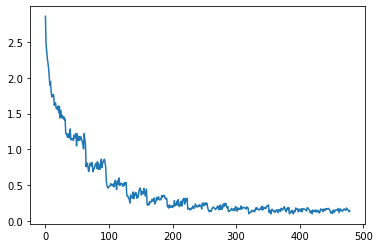

In [26]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

In [31]:
test_dataset = T5Dataset(data_dir="/opt/ml/dataset/")

In [32]:
import os

test_dataset.data = pd.read_csv(os.path.join(test_dataset.data_dir, test_dataset.test_file_name))

In [33]:
test_dataset.data["label"] = "no_relation"

In [34]:
test_dataset.set_preprocessor(preprocessor)
test_dataset.set_tokenizer(tokenizer)
test_dataset.preprocess()

Old: 지난 15일 MBC '탐사기획 스트레이트'가 이 사실을 보도했다.
New: klue_re text: 지난 15일 *MBC* '#탐사기획 스트레이트#'가 이 사실을 보도했다.
Old: 사랑스러운 ‘프린세스 프링’의 이름은 봄의 공주님: Princess(s)Pring이란 뜻으로 탄생, 부활, 청춘 등 여러 가지 의미를 담아 생일왕국의 공주님의 이름이 되었다.
New: klue_re text: 사랑스러운 ‘*프린세스 프링*’의 이름은 봄의 공주님: Princess(s)Pring이란 뜻으로 탄생, 부활, 청춘 등 여러 가지 의미를 담아 생일왕국의 #공주#님의 이름이 되었다.
Old: 한편, 본인(이근안)을 모델로 한 MBC 특집드라마 가 1995년 6.25 특집극으로 편성될 예정이었는데 제작비 문제 때문에 연출자 고석만 PD(당시 단막극 팀장)가 MBC에 지원을 요청했지만 거절당한 데다 MBC가 경찰과의 관계 약화를 염려하여 제작을 달갑지 않게 여겼고 이 과정에서 연출자가 1995년 3월 29일 MBC에 사표를 제출한 후 프리랜서를 선언하여 편성이 무산됐으며 고석만 PD는 의 제작과 관련한 MBC와의 마찰 외에도 1994년 10월 "평프로듀서로 일하고 싶다"며 당시 맡고 있던 단막극 책임PD(종합병원 전원일기 등등) 보직 사퇴의사를 밝혔지만 MBC 측의 반대로 무산되자 프리랜서를 선언했다.
New: klue_re text: 한편, 본인(이근안)을 모델로 한 MBC 특집드라마 가 *1995년* 6.25 특집극으로 편성될 예정이었는데 제작비 문제 때문에 연출자 고석만 PD(당시 단막극 팀장)가 MBC에 지원을 요청했지만 거절당한 데다 MBC가 #경찰#과의 관계 약화를 염려하여 제작을 달갑지 않게 여겼고 이 과정에서 연출자가 1995년 3월 29일 MBC에 사표를 제출한 후 프리랜서를 선언하여 편성이 무산됐으며 고석만 PD는 의 제작과 관련한 MBC와의 마찰 외에도 1994년 10월 "평프로듀서로 일하고 싶다"며 당시 맡고 있던 단막극 책임PD(종합병원 전원일기 

In [35]:
BATCH_SIZE = 8

test_dataloader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [36]:
import pickle as pickle

def num_to_label(label):
  """
    숫자로 되어 있던 class를 원본 문자열 라벨로 변환 합니다.
  """
  origin_label = []
  with open('/opt/ml/code/dict_num_to_label.pkl', 'rb') as f:
    dict_num_to_label = pickle.load(f)
  for v in label:
    origin_label.append(dict_num_to_label[v])
  return origin_label

In [34]:
output_pred = []
output_prob = []

model.eval()
with torch.no_grad():

    for idx, inputs in tqdm(enumerate(test_dataloader), total=len(test_dataset)//BATCH_SIZE):

        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = inputs['labels'].to(device)

        outputs = model(input_ids, attention_mask, labels=labels)
        prob = F.softmax(outputs.logits, dim=-1).detach().cpu().numpy()

        answers = np.argmax(prob, axis=-1)

        output_pred.append(answers)
        output_prob.append(prob)

971it [00:47, 20.33it/s]


In [37]:
answers = np.concatenate(output_pred).tolist()
answers = num_to_label(answers)
probs   = np.concatenate(output_prob, axis=0).tolist()

In [38]:
answers

['no_relation',
 'per:alternate_names',
 'no_relation',
 'no_relation',
 'per:title',
 'no_relation',
 'per:title',
 'per:spouse',
 'org:place_of_headquarters',
 'no_relation',
 'per:product',
 'no_relation',
 'org:members',
 'no_relation',
 'no_relation',
 'org:top_members/employees',
 'per:date_of_birth',
 'no_relation',
 'no_relation',
 'org:top_members/employees',
 'no_relation',
 'org:top_members/employees',
 'org:top_members/employees',
 'org:top_members/employees',
 'org:top_members/employees',
 'no_relation',
 'no_relation',
 'no_relation',
 'per:title',
 'no_relation',
 'no_relation',
 'no_relation',
 'no_relation',
 'org:member_of',
 'no_relation',
 'per:title',
 'no_relation',
 'org:product',
 'no_relation',
 'org:top_members/employees',
 'org:top_members/employees',
 'no_relation',
 'no_relation',
 'org:place_of_headquarters',
 'per:title',
 'no_relation',
 'no_relation',
 'no_relation',
 'no_relation',
 'org:member_of',
 'org:product',
 'no_relation',
 'no_relation',
 'per

In [39]:
probs

[[0.9489660263061523,
  0.0010562142124399543,
  0.00013125449186190963,
  0.0011997935362160206,
  0.00039863685378804803,
  0.0020127655006945133,
  0.04322751238942146,
  6.465117621701211e-05,
  0.0005089429905638099,
  1.3054933333478402e-05,
  2.311028765689116e-05,
  2.6032308596768416e-05,
  0.0005720104672946036,
  1.056306700775167e-05,
  0.0004487321712076664,
  7.07312356098555e-05,
  3.9560971345053986e-05,
  0.00012967844668310136,
  7.217926031444222e-05,
  3.5283668694319203e-05,
  0.0006820972193963826,
  8.202591743611265e-06,
  4.455880116438493e-06,
  7.002489292062819e-05,
  3.447223934927024e-05,
  0.0001050648934324272,
  1.1824957937278668e-06,
  6.564517320839514e-07,
  7.845857180655003e-05,
  8.636326128907967e-06],
 [1.3213852071203291e-05,
  2.0258600841316365e-07,
  9.504165632279182e-08,
  2.447629412927199e-06,
  1.891622378025204e-05,
  0.00011344192898832262,
  5.9094065363751724e-05,
  4.679033338561567e-07,
  0.00017321633640676737,
  9.1608228558470

In [36]:
test_dataset.data.head()

,id,sentence,sentence_length,subject_entity_word,subject_entity_start_idx,subject_entity_end_idx,subject_entity_type,object_entity_word,object_entity_start_idx,object_entity_end_idx,object_entity_type,label,source,t5_inputs
0,0,지난 15일 MBC '탐사기획 스트레이트'가 이 사실을 보도했다.,36,MBC,7,9,ORG,탐사기획 스트레이트,12,21,ORG,0,wikitree,klue_re text: 지난 15일 *MBC* '#탐사기획 스트레이트#'가 이 사...
1,1,사랑스러운 ‘프린세스 프링’의 이름은 봄의 공주님: Princess(s)Pring이...,97,프린세스 프링,7,13,PER,공주,84,85,POH,0,wikipedia,klue_re text: 사랑스러운 ‘*프린세스 프링*’의 이름은 봄의 공주님: P...
2,2,"한편, 본인(이근안)을 모델로 한 MBC 특집드라마 가 1995년 6.25 특집극으...",345,경찰,121,122,ORG,1995년,31,35,DAT,0,wikipedia,"klue_re text: 한편, 본인(이근안)을 모델로 한 MBC 특집드라마 가 *..."
3,3,정창손은 김질과 같이 대궐로 달려가 고변하며 '신은 실로 모르고 김질만 혼자 참여하...,96,세조,78,79,PER,정창손,0,2,PER,0,wikipedia,klue_re text: *정창손*은 김질과 같이 대궐로 달려가 고변하며 '신은 실...
4,4,"당시 민주당 이진련 시의원은 권영진 시장에게 ""긴급 생계자금을 왜 현금으로 지원하지...",57,민주당,3,5,ORG,권영진,16,18,PER,0,wikitree,"klue_re text: 당시 *민주당* 이진련 시의원은 #권영진# 시장에게 ""긴급..."


In [50]:
output = pd.DataFrame({"id": list(range(0, len(answers))),
                       "pred_label": answers,
                       "sentence": test_dataset.data[''],
                       "probs": probs})

output.to_csv("./submission.csv", index=False)

In [52]:
START = 10
END = START + 10

for idx, row in enumerate(output.iterrows()):
    print(row)
    if idx < START:
        continue
    elif idx > END:
        break
    print(row['pred_label'])
    print(row['sentence'])
    

(0, id                                                            0
pred_label                                          no_relation
sentence                   지난 15일 MBC '탐사기획 스트레이트'가 이 사실을 보도했다.
probs         [0.9489660263061523, 0.0010562142124399543, 0....
Name: 0, dtype: object)
(1, id                                                            1
pred_label                                  per:alternate_names
sentence      사랑스러운 ‘프린세스 프링’의 이름은 봄의 공주님: Princess(s)Pring이...
probs         [1.3213852071203291e-05, 2.0258600841316365e-0...
Name: 1, dtype: object)
(2, id                                                            2
pred_label                                          no_relation
sentence      한편, 본인(이근안)을 모델로 한 MBC 특집드라마 가 1995년 6.25 특집극으...
probs         [0.805101215839386, 0.001654725056141615, 0.00...
Name: 2, dtype: object)
(3, id                                                            3
pred_label                                          no_relation
sentence      정창

TypeError: tuple indices must be integers or slices, not str

In [2]:
submission = pd.read_csv("./submission.csv", encoding='utf-8')

In [38]:
submission['t5_input'] = test_dataset.data['t5_inputs']

In [42]:
for i, row in submission.iterrows():
    if i < 10:
        continue
    print(row['pred_label'])
    print(row['t5_input'])
    print()
    if i == 15:
        break

per:product
klue_re text: 실제로 *틱톡*의 ‘극한반전 챌린지’는 제2의 #이병헌# 감독을 꿈꾸는 영화 꿈나무들과 영상 꿈나무들 사이에서는 반드시 참여해야 하는 챌린지로 자리매김하고 있다.

no_relation
klue_re text: 그러나 *1993년* 김영삼 정권 출범 직후 안기부를 대대적으로 숙청하면서 #미림팀#은 폐지되었다.

org:members
klue_re text: 한편, *시*는 #3E# 정책에 대한 아이디어가 있는 시민들은 누구나 정책을 제안 할 수 있도록 시청 홈페이지 ‘정책소통 1번가’를 통해 온-라인으로도 제안을 접수받고 있다.

no_relation
klue_re text: 이 밖에도 *정* 시장은 ▲2020년도 예산편성 준비 철저 ▲명절 전후 공직기강 확립 ▲전남도 종합감사 대비 ▲시민의 상 수상 후보자 선정 만전 ▲제282회 광양시의회 임시회 준비 ▲#2019년# 화랑훈련 준비 만전 ▲시 현안업무 추진상황 점검 및 부서 간 협업 강조 등 당면 업무들이 시기를 일실하지 않도록 추진하라는 독려도 잊지 않았다.

no_relation
klue_re text: 도착이 늦어져 *리산드로스*를 죽게 한 파우사니아스는 재판에 회부당했고, 유죄 판결이 내려지기 전에 #테게아#로 망명했다.

org:top_members/employees
klue_re text: 또, *한명진* 예비후보는 “2003년 #노무현# 대통령의 ‘다음 5년 내지 10년 동안 먹고 살 수 있는 먹거리’를 준비하라는 지시로 또 다른 미래 투자인 우주개발 예산을 검토했다”라며 “우리의 국가방위 차원뿐만 아니라 우리나라의 방산물자 수출도 지속적으로 증대되고 있기 때문에 드론과 첨단 우주항공 방위산업단지는 국가적으로도 필요하다”라고 했다.

